In [1]:
import numpy as np
import h5py
import cv2
import os, sys
import argparse
from core.produce_denoised_img import produce_denoised_img
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img
from core.get_args import get_args
from copy import deepcopy as dcpy
%load_ext autoreload
%autoreload 2

In [2]:
data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned"

In [10]:
cv2.adaptiveThreshold?

Docstring:
adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst]) -> dst
.   @brief Applies an adaptive threshold to an array.
.   
.   The function transforms a grayscale image to a binary image according to the formulae:
.   -   **THRESH_BINARY**
.       \f[dst(x,y) =  \fork{\texttt{maxValue}}{if \(src(x,y) > T(x,y)\)}{0}{otherwise}\f]
.   -   **THRESH_BINARY_INV**
.       \f[dst(x,y) =  \fork{0}{if \(src(x,y) > T(x,y)\)}{\texttt{maxValue}}{otherwise}\f]
.   where \f$T(x,y)\f$ is a threshold calculated individually for each pixel (see adaptiveMethod parameter).
.   
.   The function can process the image in-place.
.   
.   @param src Source 8-bit single-channel image.
.   @param dst Destination image of the same size and the same type as src.
.   @param maxValue Non-zero value assigned to the pixels for which the condition is satisfied
.   @param adaptiveMethod Adaptive thresholding algorithm to use, see #AdaptiveThresholdTypes.
.   The #BORDER_REPLICATE

In [24]:
debug = True
for set_path in sorted(os.listdir(data_path)):
    if debug is True:
        print(set_path)
    set_path = os.path.join(data_path,set_path)
    img_list = sorted(os.listdir(set_path))
    img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
    if debug is True:
        print(img_list)
    for img_path in img_list:
        img_name = img_path
        img_path = os.path.join(set_path,img_path)
        if debug is True:
            print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        if debug is True:
            print(img.shape)
        print(img_name)
        #watershed_per_img(img_name,img,
        #                  fill_range=40,debug=True,im_save=False)
        sys.exit(-1)

SET1
['F16_1.png', 'F16_10.png', 'F16_11.png', 'F16_12.png', 'F16_13.png', 'F16_14.png', 'F16_15.png', 'F16_16.png', 'F16_2.png', 'F16_3.png', 'F16_4.png', 'F16_5.png', 'F16_6.png', 'F16_7.png', 'F16_8.png', 'F16_9.png', 'F32_1.png', 'F32_10.png', 'F32_11.png', 'F32_12.png', 'F32_13.png', 'F32_14.png', 'F32_15.png', 'F32_16.png', 'F32_2.png', 'F32_3.png', 'F32_4.png', 'F32_5.png', 'F32_6.png', 'F32_7.png', 'F32_8.png', 'F32_9.png', 'F64_1.png', 'F64_10.png', 'F64_11.png', 'F64_12.png', 'F64_13.png', 'F64_14.png', 'F64_15.png', 'F64_16.png', 'F64_2.png', 'F64_3.png', 'F64_4.png', 'F64_5.png', 'F64_6.png', 'F64_7.png', 'F64_8.png', 'F64_9.png', 'F8_1.png', 'F8_10.png', 'F8_11.png', 'F8_12.png', 'F8_13.png', 'F8_14.png', 'F8_15.png', 'F8_16.png', 'F8_2.png', 'F8_3.png', 'F8_4.png', 'F8_5.png', 'F8_6.png', 'F8_7.png', 'F8_8.png', 'F8_9.png']
/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned/SET1/F16_1.png
(1474, 3010)
F16_1.png


SystemExit: -1

/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


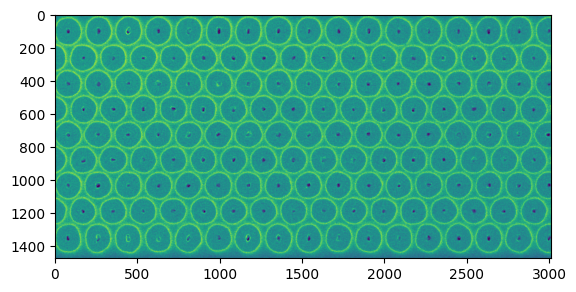

In [4]:
plt.imshow(img)

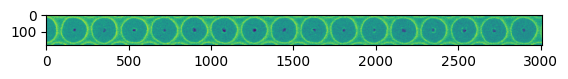

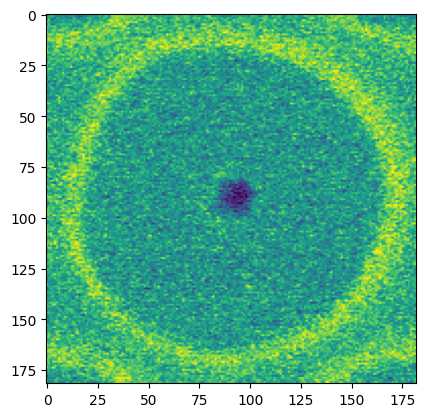

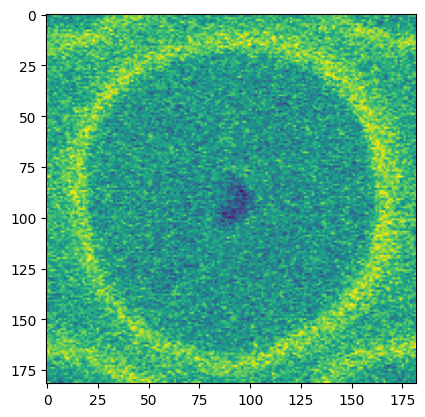

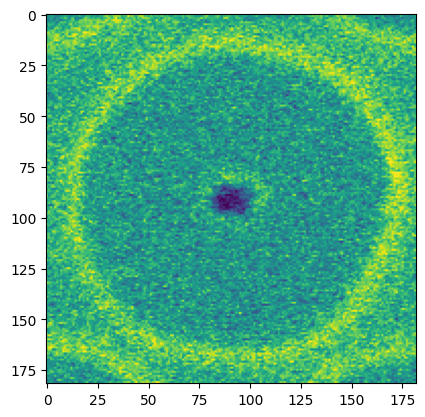

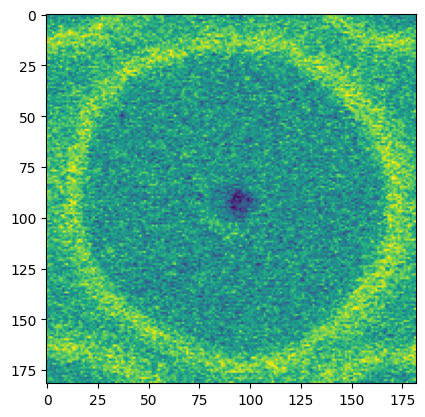

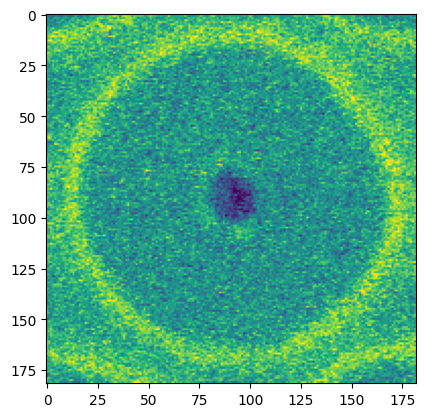

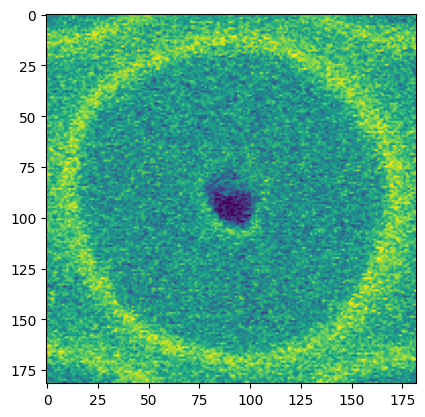

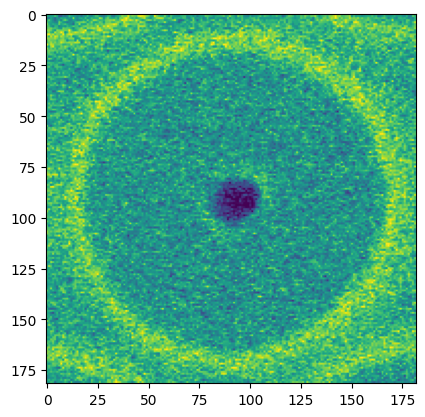

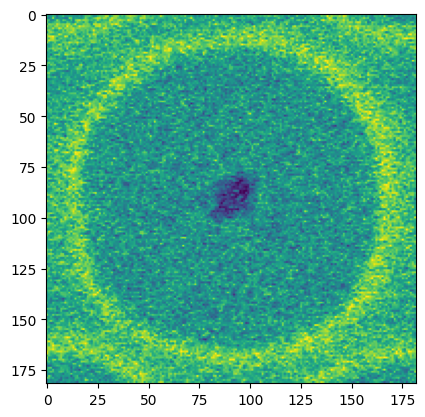

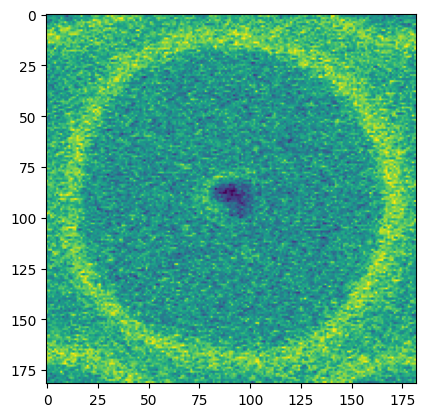

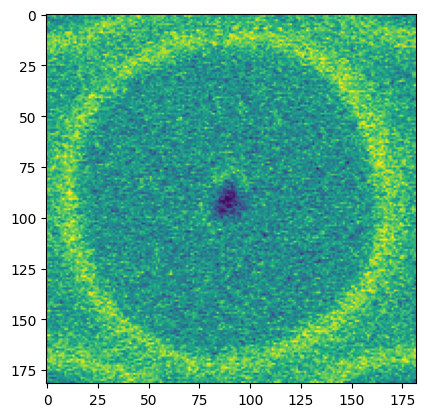

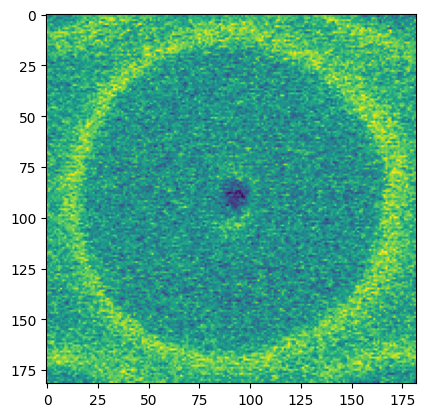

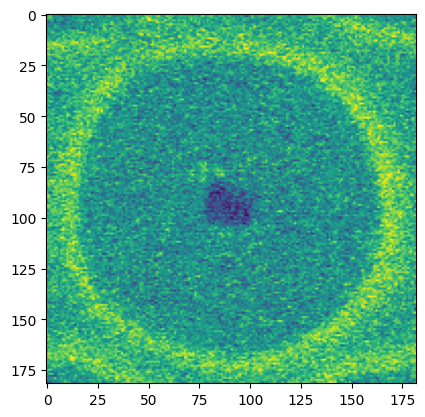

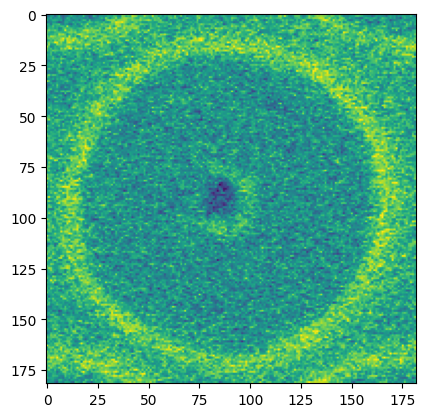

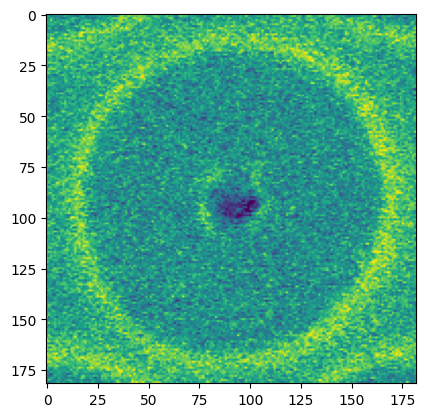

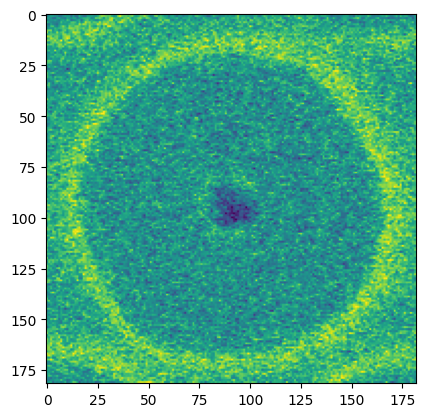

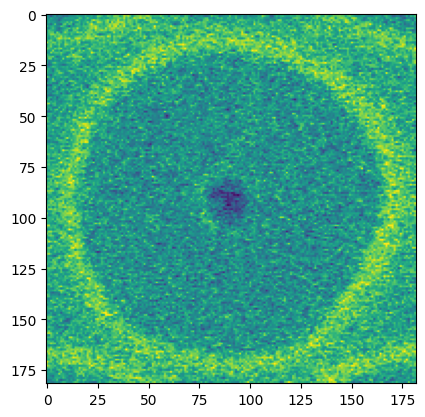

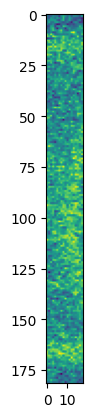

In [5]:
crop_size = 182
left = 80
top = 170    
plt.imshow(img[top:top+crop_size])
plt.pause(0.01)
while left <= img.shape[1]:
    plt.imshow(img[top:top+crop_size,left:left+crop_size])
    plt.pause(0.01)
    left += crop_size


In [6]:
pge_weight_dir = "221005_PGE_Net_Grayscale_Samsung_SET1_Noise_est_cropsize_256.w"
fbi_weight_dir = "../weights/221005_FBI_Net_Grayscale_Samsung_SET1_MSE_Affine_layers_x17_filters_x64_cropsize_256.w"
te_data_dir = f'../data/val_Samsung_SNU_patches_SET1.hdf5'
            
args = get_args()
args.pge_weight_dir = pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'FBI_Net'
args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
args.crop_size = 200
args.debug = False
args

Namespace(date='', seed=0, noise_type='Poisson-Gaussian', loss_function='MSE_Affine', model_type='FBI_Net', data_type='Grayscale', data_name='Samsung', nepochs=50, batch_size=4, lr=0.001, drop_rate=0.5, drop_epoch=10, crop_size=200, alpha=0.01, beta=0.02, num_layers=17, num_filters=64, mul=1, unet_layer=3, pge_weight_dir='221005_PGE_Net_Grayscale_Samsung_SET1_Noise_est_cropsize_256.w', output_type='sigmoid', sigmoid_value=0.1, use_other_target=False, x_f_num='F1', y_f_num='F64', integrate_all_set=False, set_num='1', test=False, train_with_MSEAffine=False, debug=False)

In [8]:
img_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned/SET1/F16_1.png"
img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
model = produce_denoised_img(_pge_weight_dir=pge_weight_dir,_fbi_weight_dir = fbi_weight_dir,_args = args)
img = model.eval(img)

output type : linear


In [9]:
img = (img*255.).astype('uint8')

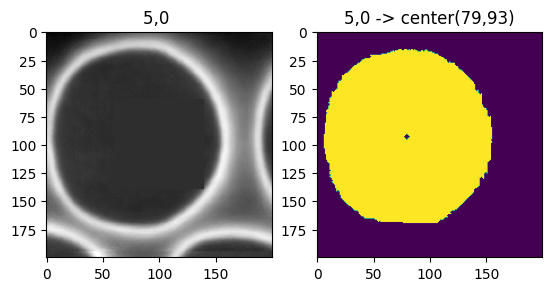

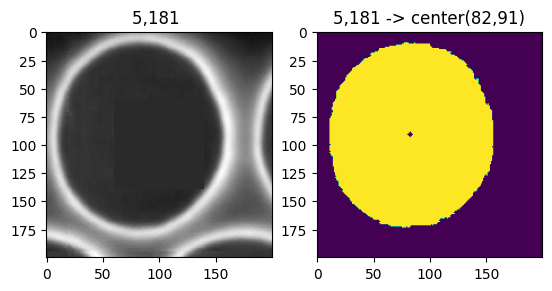

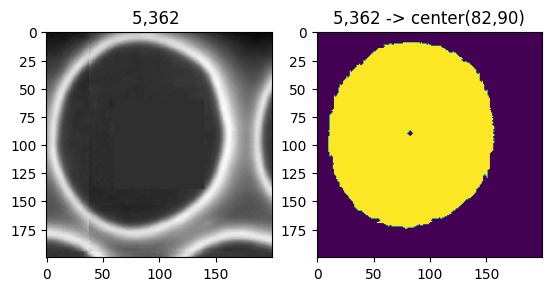

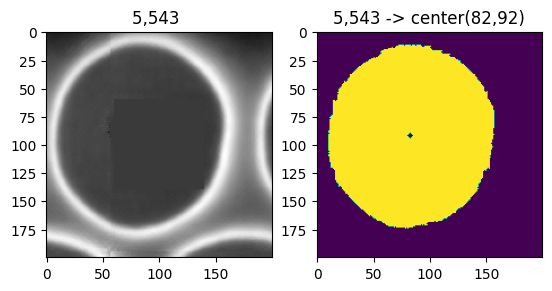

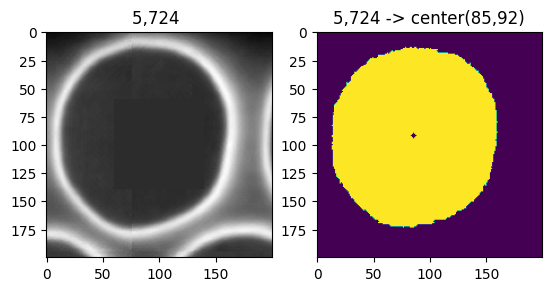

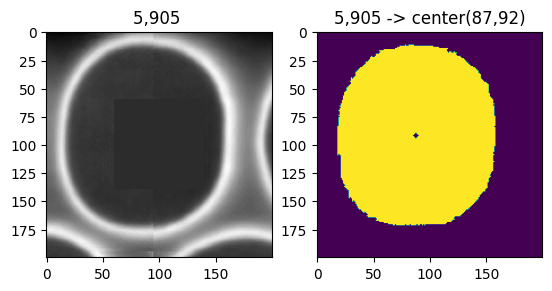

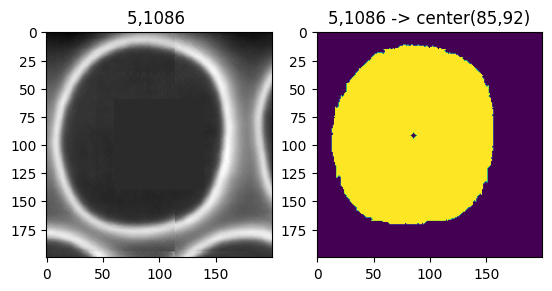

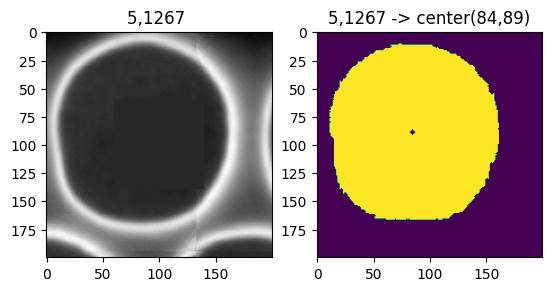

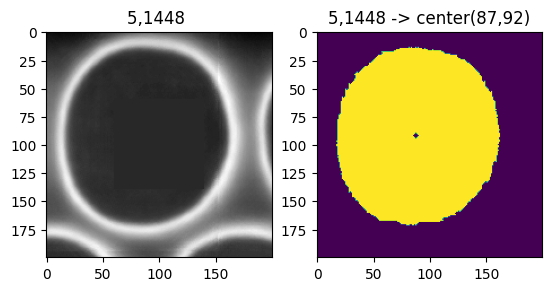

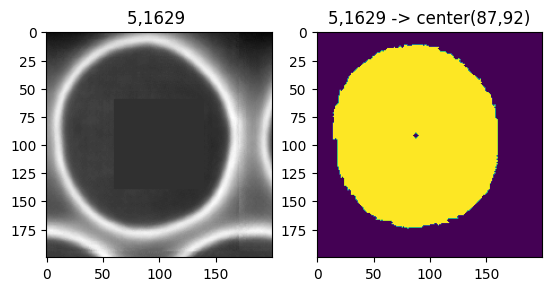

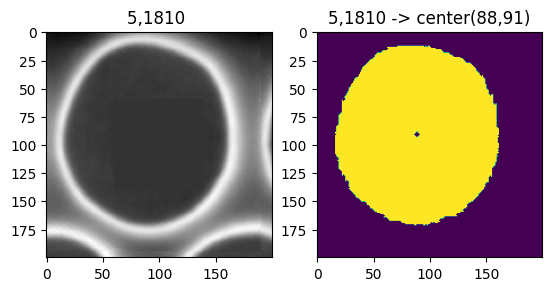

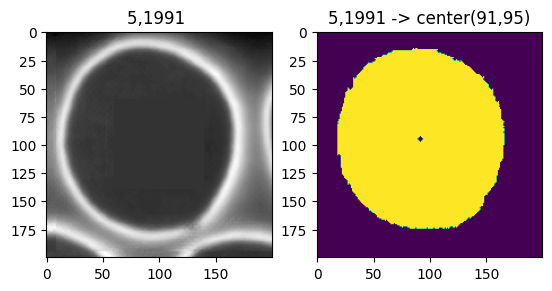

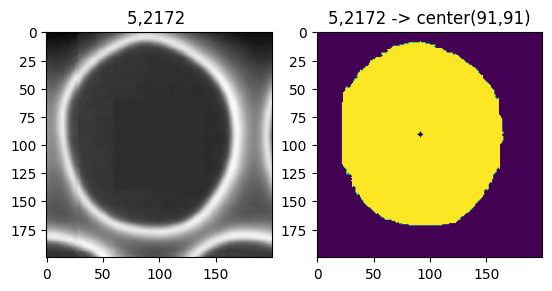

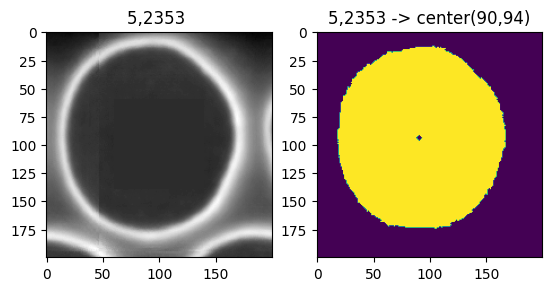

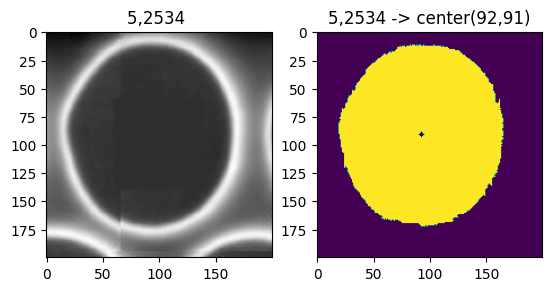

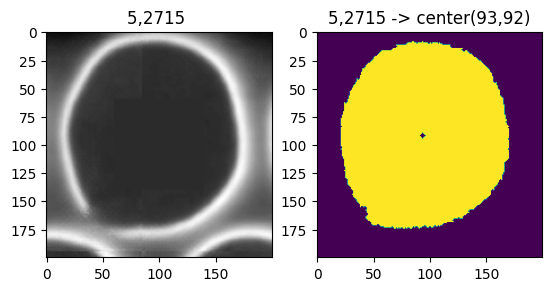

5,2896 img shape mismatch


<Figure size 640x480 with 0 Axes>

In [20]:
odd_row = True
crop_size=200#190
top_shift_size = 165
left_shift_size = 181
debug = False
im_show = True
im_save = True
img_name = "test"
idx = 0
offset_for_top = 18
top = 5
os.makedirs(f"segmentation_img/{img_name}",exist_ok=True)
while top < img.shape[0]:
# for idx,top in enumerate(range(0,img.shape[0],top_crop_size)):
    if debug is True:
        plt.imshow(img[top:top+crop_size])
        plt.pause(0.01)
    odd_row = True if idx % 2 == 1 else False
    for left in range(0,img.shape[1],left_shift_size):
        if odd_row is True:
            left += 80
        target_img = dcpy(img[top:top+crop_size,left:left+crop_size])
        if target_img.shape != (crop_size,crop_size):
            print(f"{top},{left} img shape mismatch")
            break
        # fill_range = 40
        # x_mid = target_img.shape[0]//2
        # y_mid = target_img.shape[1] // 2
        # target_img[x_mid-fill_range:x_mid+fill_range,y_mid-fill_range:y_mid+fill_range] = 140

        (cX,cY),segmented_img = watershed(target_img,debug)
        if debug is True or im_show is True:
            plt.subplot(121)
            plt.title(f"{top},{left} ")
            plt.imshow(target_img,cmap='gray')
            plt.subplot(122)
            plt.title(f"{top},{left} -> center({cX},{cY})")
            plt.imshow(segmented_img)
            plt.pause(0.01)
            if im_save is True:
                plt.savefig(f"./segmentation_img/{img_name}/({top:04d},{left:04d})")
            
            
        if debug is True and left > 500 :
            break
    

    # update for 1st for loop
    idx +=1
    top += top_shift_size
    if odd_row is True:
        top -= offset_for_top

[-1  1  2  3  4  5  6  7  8]
cricle_value is 4
90 94


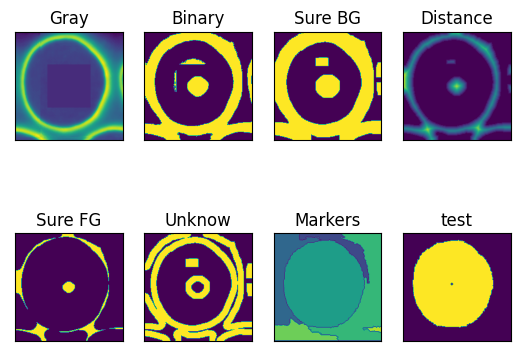

In [208]:
# for test
top = 5
left = 2353
crop_size = 200#190
target_img = dcpy(img[top:top+crop_size,left:left+crop_size])

(cX,cY), output = watershed(target_img,True)


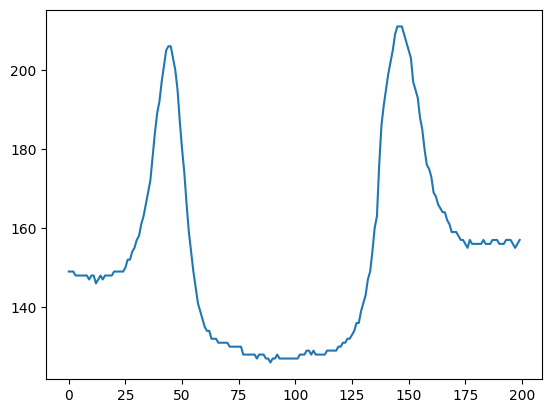

In [191]:
plt.plot(target_img[150])